# Final Dissertation Code

In [1]:
# These are some packages needs to be installed before runing the code. Restarting the terminal is required after installing the packages.
# Necessary libraries
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install accelerate>=0.21.0
!pip install transformers[torch] accelerate -U
!pip install tensorflow==2.6.0
!pip install tf-keras
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
ERROR: Could not find a version that satisfies the requirement

In [3]:
# Connecting to google drive for dataset on colab
# Note; This step is not required when runing on jupyter notebook.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Reading The Data

In [5]:
project_data = pd.read_csv("/content/drive/My Drive/IMDB Dataset.csv")

In [6]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
print(f"shape of data frame: {project_data.shape}\n ")

shape of data frame: (50000, 2)
 


In [8]:
print(f"Column names:- '{project_data.columns[0]}' and '{project_data.columns[1]}'")
print(f"Number of reviews:- {len(project_data['review'])}")
print(f"Unique sentiment classification:- '{project_data['sentiment'].unique()[0]}' and '{project_data['sentiment'].unique()[1]}'")

Column names:- 'review' and 'sentiment'
Number of reviews:- 50000
Unique sentiment classification:- 'positive' and 'negative'


In [9]:
# Overview of our data
project_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data pre-processing

## Check Null and Duplicate Values

In [10]:
# NUll Values
print(f"Null values in columns:\n{project_data.isna().sum()}")

# Duplicated Values
print(f"\nDuplicate values in the dataset:- {project_data.duplicated().sum()}")

Null values in columns:
review       0
sentiment    0
dtype: int64

Duplicate values in the dataset:- 418


In [11]:
# Removing Duplicated values
project_data = project_data.drop_duplicates()

In [12]:
project_data.duplicated().sum()

0

In [13]:
project_data.rename(columns = {'review':'text'}, inplace = True)

## Removing URL

In [14]:
project_data.head(2)

,text,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [15]:
import re

def removing_urls(text):
    regx_url = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    clean_text = re.sub(regx_url, '', text)
    return clean_text


In [16]:
project_data['text'] = project_data['text'].apply(lambda x: removing_urls(x) if isinstance(x, str) else x)

## Convert Text To lower Case

In [17]:
project_data['text'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [18]:
project_data['text'][2].lower()

'i thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. the plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). while some may be disappointed when they realize this is not match point 2: risk addiction, i thought it was proof that woody allen is still fully in control of the style many of us have grown to love.<br /><br />this was the most i\'d laughed at one of woody\'s comedies in years (dare i say a decade?). while i\'ve never been impressed with scarlet johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />this may not be the crown jewel of his career, but it was wittier than "devil wears prada" and more interesting than "superman" a great comedy to go see with friends.'

In [19]:
def low(text):
    return text.lower()

In [20]:
project_data['text'] = project_data['text'].apply(low)

In [21]:
project_data.head(4)

,text,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative


## Remove Punctuation and special Characters

In [22]:
project_data['text'][3]

"basically there's a family where a little boy (jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />this movie is slower than a soap opera... and suddenly, jake decides to become rambo and kill the zombie.<br /><br />ok, first of all when you're going to make a film you must decide if its a thriller or a drama! as a drama the movie is watchable. parents are divorcing & arguing like in real life. and then we have jake with his closet which totally ruins all the film! i expected to see a boogeyman similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. as for the shots with jake: just ignore them."

In [23]:
re.findall(r'[^a-zA-Z\s]',project_data['text'][3])[:10]

["'", '(', ')', "'", '&', '.', '<', '/', '>', '<']

In [24]:
len(re.findall(r'[^a-zA-Z\s]',project_data['text'][3]))

45

In [25]:
re.sub(r'[^a-zA-Z\s]','',project_data['text'][3])

'basically theres a family where a little boy jake thinks theres a zombie in his closet  his parents are fighting all the timebr br this movie is slower than a soap opera and suddenly jake decides to become rambo and kill the zombiebr br ok first of all when youre going to make a film you must decide if its a thriller or a drama as a drama the movie is watchable parents are divorcing  arguing like in real life and then we have jake with his closet which totally ruins all the film i expected to see a boogeyman similar movie and instead i watched a drama with some meaningless thriller spotsbr br  out of  just for the well playing parents  descent dialogs as for the shots with jake just ignore them'

In [26]:
project_data['text'] = project_data['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

In [27]:
project_data['text'][2]

'i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a lighthearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point  risk addiction i thought it was proof that woody allen is still fully in control of the style many of us have grown to lovebr br this was the most id laughed at one of woodys comedies in years dare i say a decade while ive never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into a average but spirited young womanbr br this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman a great comedy to go see with friends'

## Remove Numbers

In [28]:
project_data['text'] = project_data['text'].apply(lambda x: re.sub(r'\d+','',x))

In [29]:
project_data.head(2)

,text,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production br br the filmin...,positive


## Remove Extra White spaces

In [30]:
project_data['text'][3]

'basically theres a family where a little boy jake thinks theres a zombie in his closet  his parents are fighting all the timebr br this movie is slower than a soap opera and suddenly jake decides to become rambo and kill the zombiebr br ok first of all when youre going to make a film you must decide if its a thriller or a drama as a drama the movie is watchable parents are divorcing  arguing like in real life and then we have jake with his closet which totally ruins all the film i expected to see a boogeyman similar movie and instead i watched a drama with some meaningless thriller spotsbr br  out of  just for the well playing parents  descent dialogs as for the shots with jake just ignore them'

In [31]:
re.sub(r'\s+', ' ', project_data['text'][3]).strip()

'basically theres a family where a little boy jake thinks theres a zombie in his closet his parents are fighting all the timebr br this movie is slower than a soap opera and suddenly jake decides to become rambo and kill the zombiebr br ok first of all when youre going to make a film you must decide if its a thriller or a drama as a drama the movie is watchable parents are divorcing arguing like in real life and then we have jake with his closet which totally ruins all the film i expected to see a boogeyman similar movie and instead i watched a drama with some meaningless thriller spotsbr br out of just for the well playing parents descent dialogs as for the shots with jake just ignore them'

In [32]:
def remove_extra_white_spaces(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [33]:
project_data['text'] = project_data['text'].apply(remove_extra_white_spaces)

## Removing Stop words

In [34]:
len(set(stopwords.words('english')))

179

In [35]:
from wordcloud import WordCloud, STOPWORDS

len(set(STOPWORDS)) ## The are more stop in word cloud so we will consider this

192

In [36]:
word_tokenize(project_data['text'][2])[:25]

['i',
 'thought',
 'this',
 'was',
 'a',
 'wonderful',
 'way',
 'to',
 'spend',
 'time',
 'on',
 'a',
 'too',
 'hot',
 'summer',
 'weekend',
 'sitting',
 'in',
 'the',
 'air',
 'conditioned',
 'theater',
 'and',
 'watching',
 'a']

In [37]:
## logic for stop words
stop_words = set(STOPWORDS)
temp_filter = []

temp_words = word_tokenize(project_data['text'][2])
for words in temp_words:
    if words not in stop_words:
        temp_filter.append(words)

print(temp_filter)
' '.join(temp_filter)

['thought', 'wonderful', 'way', 'spend', 'time', 'hot', 'summer', 'weekend', 'sitting', 'air', 'conditioned', 'theater', 'watching', 'lighthearted', 'comedy', 'plot', 'simplistic', 'dialogue', 'witty', 'characters', 'likable', 'even', 'well', 'bread', 'suspected', 'serial', 'killer', 'may', 'disappointed', 'realize', 'match', 'point', 'risk', 'addiction', 'thought', 'proof', 'woody', 'allen', 'still', 'fully', 'control', 'style', 'many', 'us', 'grown', 'lovebr', 'br', 'id', 'laughed', 'one', 'woodys', 'comedies', 'years', 'dare', 'say', 'decade', 'ive', 'never', 'impressed', 'scarlet', 'johanson', 'managed', 'tone', 'sexy', 'image', 'jumped', 'right', 'average', 'spirited', 'young', 'womanbr', 'br', 'may', 'crown', 'jewel', 'career', 'wittier', 'devil', 'wears', 'prada', 'interesting', 'superman', 'great', 'comedy', 'go', 'see', 'friends']


'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching lighthearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown lovebr br id laughed one woodys comedies years dare say decade ive never impressed scarlet johanson managed tone sexy image jumped right average spirited young womanbr br may crown jewel career wittier devil wears prada interesting superman great comedy go see friends'

In [38]:
stop_words = set(STOPWORDS)

def removing_stopwords(text):
    words = word_tokenize(text)
    required_words = []
    for word in words:
        if word not in stop_words:
            required_words.append(word)
    return ' '.join(required_words)

In [39]:
project_data['text'] = project_data['text'].apply(removing_stopwords)

In [40]:
project_data.head()

,text,sentiment
0,one reviewers mentioned watching oz episode yo...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


## Lemmatization

In [41]:
temp_data = project_data.copy()

In [42]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

project_data['text'] = project_data['text'].apply(lemmatize_text)

# Data Visualization


## Movie Review Sentiment Classification

In [43]:
classification = project_data['sentiment'].value_counts().reset_index()
viz_proj_data = project_data.copy()

In [44]:
classification

,sentiment,count
0,positive,24884
1,negative,24698


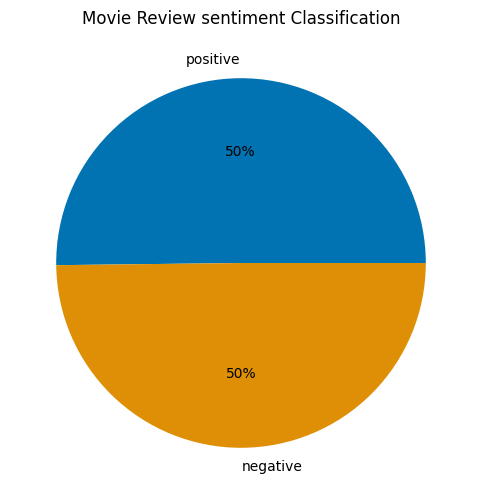

In [45]:
palette_color = sns.color_palette('colorblind')
plt.figure(figsize = (8,6))
plt.pie(x=classification['count'], labels=classification['sentiment'],colors=palette_color, autopct='%.0f%%')
plt.title('Movie Review sentiment Classification')
plt.show()

## Distribution Of Review Length

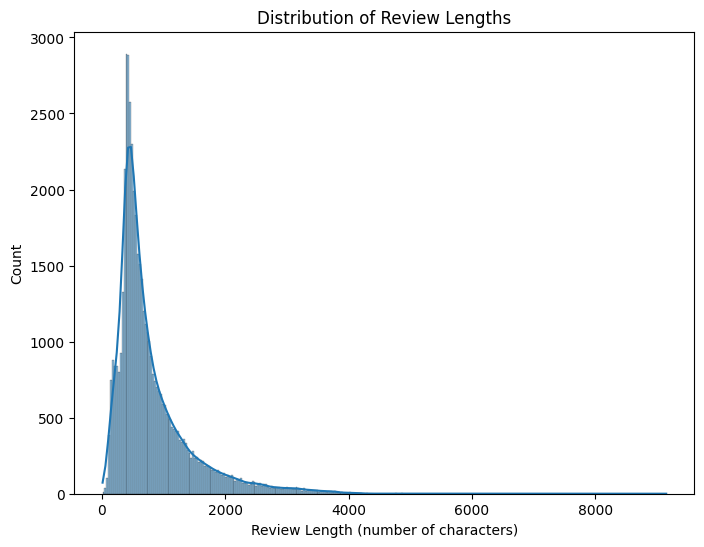

In [46]:
# Distribution plot for review length
plt.figure(figsize = (8,6))
viz_proj_data['review_length'] = viz_proj_data['text'].apply(len)
sns.histplot(viz_proj_data['review_length'], kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (number of characters)')
plt.ylabel('Count')
plt.show()

## Distribution of Review Word Counts

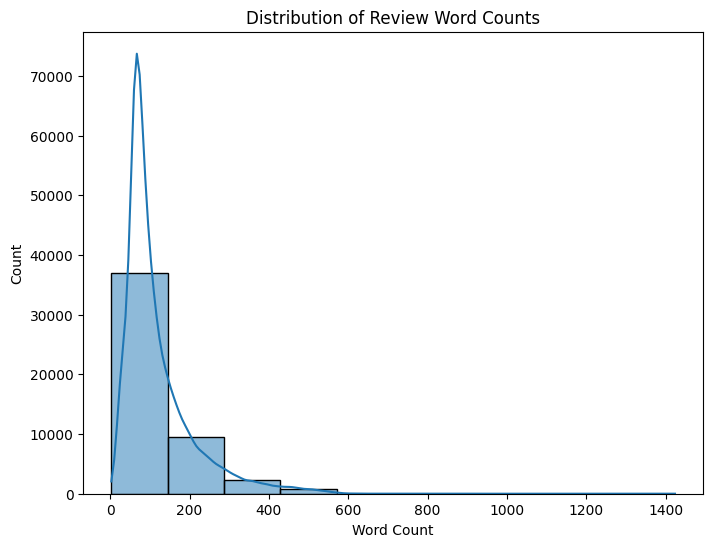

In [47]:
# Distribution plot for review word count
plt.figure(figsize = (8,6))
viz_proj_data['word_count'] = viz_proj_data['text'].apply(lambda x: len(x.split()))
sns.histplot(viz_proj_data['word_count'], kde=True, bins=10)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

## Distribution of Text Lengths

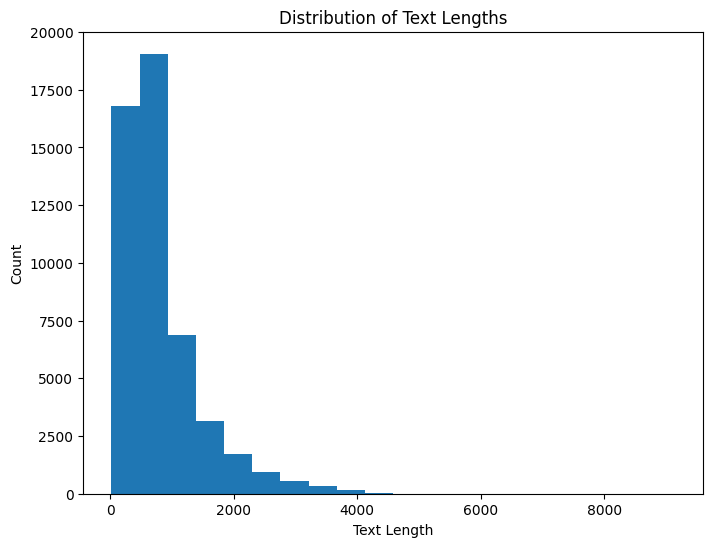

In [48]:
plt.figure(figsize = (8,6))
viz_proj_data['text_length'] = viz_proj_data['text'].apply(len)
plt.hist(viz_proj_data['text_length'], bins=20)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

## Top 20 words from Data

In [49]:
text_data = viz_proj_data['text']
word_freq = {}

for text in text_data:
    words = text.lower().split()

    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

# Get the top 20 words
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = dict(sorted_word_freq[:20])
top_words

{'br': 114045,
 'movie': 98234,
 'film': 89135,
 'one': 52910,
 'time': 29116,
 'good': 28483,
 'character': 27373,
 'even': 24375,
 'story': 24110,
 'make': 23437,
 'see': 23384,
 'really': 22781,
 'scene': 20560,
 'well': 18818,
 'much': 18783,
 'will': 17934,
 'people': 17871,
 'great': 17776,
 'bad': 17539,
 'first': 17010}

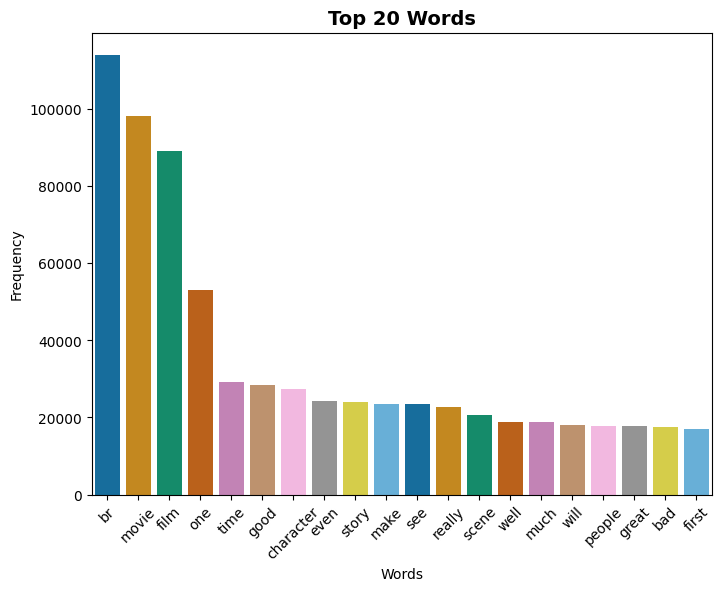

In [50]:
top_20_words = dict(sorted_word_freq[:20])

plt.figure(figsize=(8, 6))
sns.barplot(x= list(top_20_words.keys()) , y= list(top_20_words.values()),palette="colorblind")
plt.title("Top 20 Words", fontsize = 14, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=45)
plt.show()


As we can see 'br' is a neutral word and is repeated in most of the sentences, 'br' is like a outlier  and is something we dont need in our analysis so will remove br and some more neutral words from our project_data

## Removing Outliers

In [51]:
project_data['text'][1]

'wonderful little production br br filming technique unassuming oldtimebbc fashion give comforting sometimes discomforting sense realism entire piece br br actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life br br realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwells mural decorating every surface terribly well done'

We can see in the first line we have 'br' repeated twice in that text sentence so we will remove it.

In [52]:
neutral_words = set(["im","br","go", "got","today","u", "lol","na",'amp'])

txt = project_data['text'][1]
clean_sentence = []

for word in txt.split():
    if word.lower() not in neutral_words:
        clean_sentence.append(word)

print(clean_sentence)
' '.join(clean_sentence)

['wonderful', 'little', 'production', 'filming', 'technique', 'unassuming', 'oldtimebbc', 'fashion', 'give', 'comforting', 'sometimes', 'discomforting', 'sense', 'realism', 'entire', 'piece', 'actor', 'extremely', 'well', 'chosen', 'michael', 'sheen', 'polari', 'voice', 'pat', 'truly', 'see', 'seamless', 'editing', 'guided', 'reference', 'williams', 'diary', 'entry', 'well', 'worth', 'watching', 'terrificly', 'written', 'performed', 'piece', 'masterful', 'production', 'one', 'great', 'master', 'comedy', 'life', 'realism', 'really', 'come', 'home', 'little', 'thing', 'fantasy', 'guard', 'rather', 'use', 'traditional', 'dream', 'technique', 'remains', 'solid', 'disappears', 'play', 'knowledge', 'sens', 'particularly', 'scene', 'concerning', 'orton', 'halliwell', 'set', 'particularly', 'flat', 'halliwells', 'mural', 'decorating', 'every', 'surface', 'terribly', 'well', 'done']


'wonderful little production filming technique unassuming oldtimebbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwells mural decorating every surface terribly well done'

we have successfully removed the neutral words we dont need for our analysis

In [53]:
neutral_words = set(["im","br","go", "got","today","u", "lol","na",'amp'])

# Function to remove neutral words from text
def remove_neutral_words(text):
    return ' '.join([word for word in text.split() if word.lower() not in neutral_words])

project_data['text'] = project_data['text'].apply(remove_neutral_words)
viz_proj_data['text'] = viz_proj_data['text'].apply(remove_neutral_words)

## Top 20 words from labeled as positive

In [54]:
positive_text_data = viz_proj_data[viz_proj_data['sentiment'] == 'positive']['text']

word_freq = {}

for text in positive_text_data:
    words = text.lower().split()
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_20_pos_words = dict(sorted_word_freq[:20])

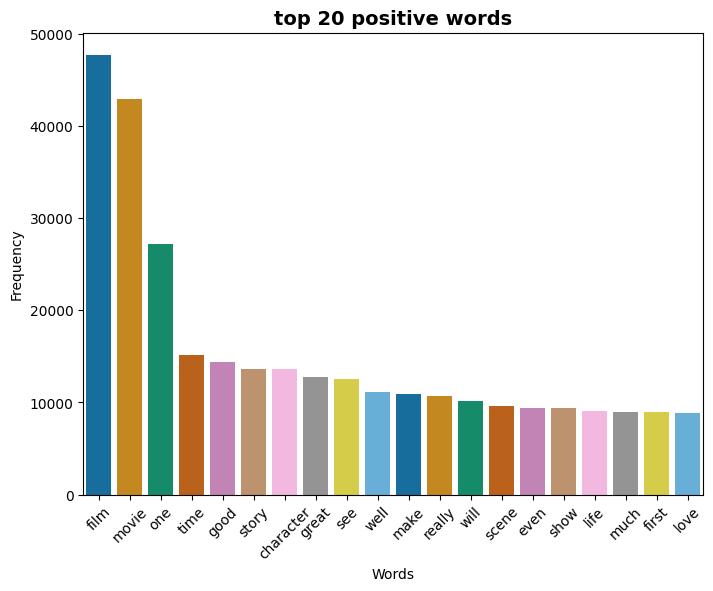

In [55]:
plt.figure(figsize=(8, 6))
sns.barplot(x= list(top_20_pos_words.keys()) , y= list(top_20_pos_words.values()), palette="colorblind")
plt.title("top 20 positive words", fontsize = 14, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=45)
plt.show()

## Top 20 words from labeled as negative

In [56]:
# Tokenize the text and count the frequency of each word
negative_text_data = viz_proj_data[viz_proj_data['sentiment'] == 'negative']['text']

word_freq = {}

for text in negative_text_data:
    words = text.lower().split()
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

# Get the top 20 words
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_20_neg_words = dict(sorted_word_freq[:20])

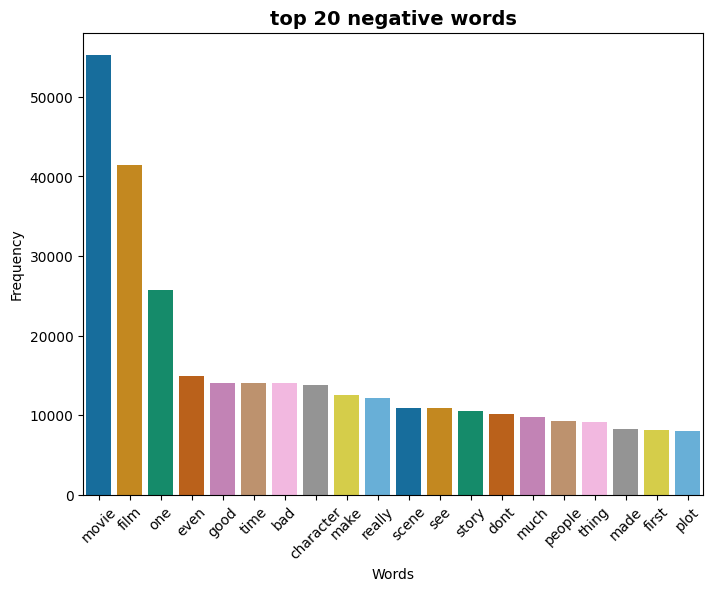

In [57]:

plt.figure(figsize=(8, 6))
sns.barplot(x= list(top_20_neg_words.keys()) , y= list(top_20_neg_words.values()),palette="colorblind")
plt.title("top 20 negative words", fontsize = 14, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=45)
plt.show()

## WordCloud Visualization

In [58]:
from wordcloud import WordCloud, STOPWORDS

In [59]:
word_cloud = ' '.join(viz_proj_data['text'])

In [60]:
wordcloud = WordCloud(stopwords = set(STOPWORDS)).generate(word_cloud)

(-0.5, 399.5, 199.5, -0.5)

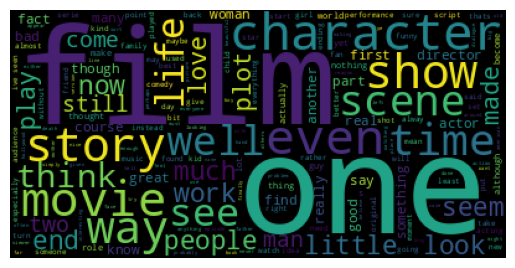

In [61]:
plt.imshow(wordcloud)
plt.axis('off')

# Machine Learnings Model

In [62]:
data = project_data[['text','sentiment']]

In [63]:
data.head()

,text,sentiment
0,one reviewer mentioned watching oz episode you...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive


In [64]:
data['sentiment'] = data['sentiment'].replace({'positive':1,'negative':0})
data.head(2)

,text,sentiment
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1


## SVM - Support Vector Machine

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = CountVectorizer()
# Transforms text data into neumerical vectors
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data['text'])

# Target variable
y = data['sentiment']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

svm_model = SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

In [68]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4939
           1       0.84      0.88      0.86      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



In [69]:
SVM_accuracy = accuracy_score(y_test, y_pred)
SVM_Precision =  precision_score(y_test, y_pred)
SVM_recall = recall_score(y_test, y_pred)
SVM_F1_Score = f1_score(y_test, y_pred)

SVM_training_accuracy = svm_model.score(X_train, y_train)
SVM_testing_accuracy = svm_model.score(X_test, y_test)

print(f"SVM Accuracy: ",SVM_accuracy)
print(f"SVM Precision: ",SVM_Precision)
print(f"SVM Recall: ",SVM_recall)
print(f"SVM F1 Score: ",SVM_F1_Score)
print(f"SVM Training Accuracy: ",SVM_training_accuracy)
print(f"SVM Testing Accuracy: ",SVM_testing_accuracy)

SVM Accuracy:  0.8538872642936371
SVM Precision:  0.840177366493156
SVM Recall:  0.8754519887505022
SVM F1 Score:  0.8574520413182489
SVM Training Accuracy:  0.8703895121643767
SVM Testing Accuracy:  0.8538872642936371


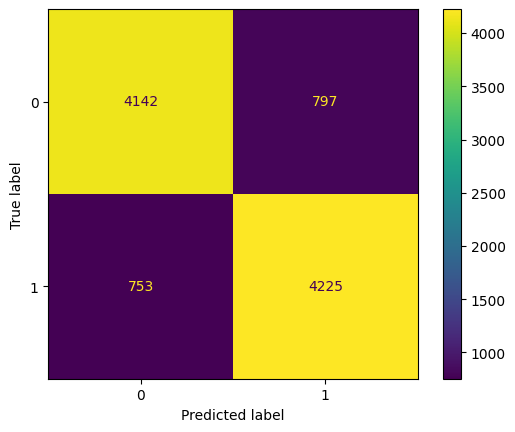

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Random Forest

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Vectorize Text Data
vectorizer = TfidfVectorizer(stop_words='english')

X = data['text']
X_vectorized = vectorizer.fit_transform(X)

y = data['sentiment']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [73]:
# Train the Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
# Make Predictions and Evaluate the Model
y_pred = rf_model.predict(X_test)

In [75]:
# Evaluate the model
RF_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {RF_accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8437027326812544
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      4939
           1       0.84      0.85      0.84      4978

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917



In [76]:
RF_accuracy = accuracy_score(y_test, y_pred)
RF_Precision =  precision_score(y_test, y_pred)
RF_recall = recall_score(y_test, y_pred)
RF_F1_Score = f1_score(y_test, y_pred)
RF_training_accuracy = rf_model.score(X_train, y_train)
RF_testing_accuracy = rf_model.score(X_test, y_test)

print(f"Random Forest Accuracy: ",RF_accuracy)
print(f"Random Forest Precision: ",RF_Precision)
print(f"Random Forest Recall: ",RF_recall)
print(f"Random Forest F1 Score: ",RF_F1_Score)
print(f"Random Forest Training Accuracy: ",RF_training_accuracy)
print(f"Random Forest Testing Accuracy: ",RF_testing_accuracy)

Random Forest Accuracy:  0.8437027326812544
Random Forest Precision:  0.8412982875348467
Random Forest Recall:  0.8487344314985938
Random Forest F1 Score:  0.845
Random Forest Training Accuracy:  1.0
Random Forest Testing Accuracy:  0.8437027326812544


In [152]:
def Sentiment_prediction(sentence):
    vectorized_sentence = vectorizer.transform([sentence])

    sentence_prediction = rf_model.predict(vectorized_sentence)
    prediction_probability = rf_model.predict_proba(vectorized_sentence)

    return sentence_prediction, prediction_probability

movie_review = 'I felt like I was 14 again. Thank you Netflix!. it was a really great film enjoyed a lot '
predicted_class = Sentiment_prediction(movie_review)[0]
predicted_probability = Sentiment_prediction(movie_review)[1]

if predicted_class == 1 : print(f"Predicted Class: {predicted_class[0]}, Positive Review")
else: print(f"Predicted Class: {predicted_class}, Negative Review")

print(f"Prediction Probability: {predicted_probability}")

Predicted Class: 1, Positive Review
Prediction Probability: [[0.09 0.91]]


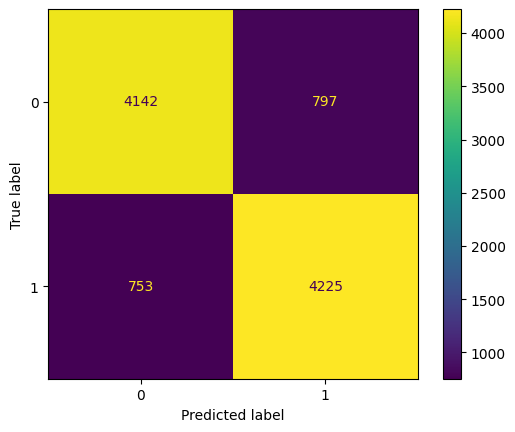

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Decision tree classifier

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd


In [81]:
# Vectorize Text Data
vectorizer = TfidfVectorizer(stop_words='english')
X = data['text']
X_vectorized = vectorizer.fit_transform(X)

In [82]:
# Train-Test Split
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


In [83]:
# Train the Decision Tree Model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)


DecisionTreeClassifier()

In [84]:
# Make Predictions and Evaluate the Model
y_pred = dt_model.predict(X_test)

# Evaluate the model
DT_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {DT_accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.7136230714933952
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      4939
           1       0.72      0.71      0.71      4978

    accuracy                           0.71      9917
   macro avg       0.71      0.71      0.71      9917
weighted avg       0.71      0.71      0.71      9917



In [85]:
DT_accuracy = accuracy_score(y_test, y_pred)
DT_Precision =  precision_score(y_test, y_pred)
DT_recall = recall_score(y_test, y_pred)
DT_F1_Score = f1_score(y_test, y_pred)
DT_training_accuracy = dt_model.score(X_train, y_train)
DT_testing_accuracy = dt_model.score(X_test, y_test)

print(f"Decision Tree Accuracy: ",DT_accuracy)
print(f"Decision Tree Precision: ",DT_Precision)
print(f"Decision Tree Recall: ",DT_recall)
print(f"Decision Tree F1 Score: ",DT_F1_Score)
print(f"Decision Tree Training Accuracy: ",DT_training_accuracy)
print(f"Decision Tree Testing Accuracy: ",DT_testing_accuracy)

Decision Tree Accuracy:  0.7136230714933952
Decision Tree Precision:  0.7167477696674777
Decision Tree Recall:  0.7101245480112495
Decision Tree F1 Score:  0.7134207870837537
Decision Tree Training Accuracy:  1.0
Decision Tree Testing Accuracy:  0.7136230714933952


In [153]:
def Sentiment_prediction(sentence):
    vectorized_sentence = vectorizer.transform([sentence])

    sentence_prediction = dt_model.predict(vectorized_sentence)
    prediction_probability = dt_model.predict_proba(vectorized_sentence)

    return sentence_prediction, prediction_probability

movie_review = 'I felt like I was 14 again. Thank you Netflix!. it was a really great film enjoyed a lot '
predicted_class = Sentiment_prediction(movie_review)[0]
predicted_probability = Sentiment_prediction(movie_review)[1]

if predicted_class == 1 : print(f"Predicted Class: {predicted_class[0]}, Positive Review")
else: print(f"Predicted Class: {predicted_class}, Negative Review")

print(f"Prediction Probability: {predicted_probability}")


Predicted Class: 1, Positive Review
Prediction Probability: [[0. 1.]]


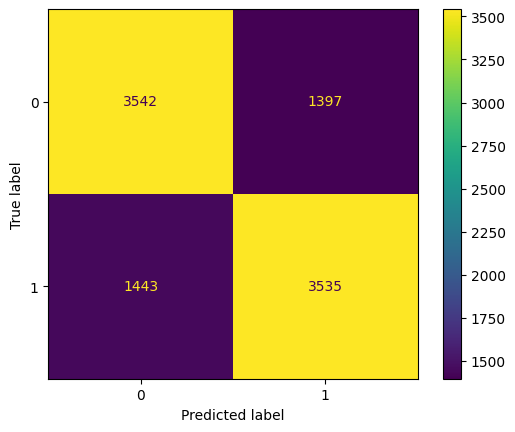

In [87]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Logistic Regression

In [88]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [89]:

# Vectorize Text Data
vectorizer = TfidfVectorizer(stop_words='english')
X = data['text']
X_vectorized = vectorizer.fit_transform(X)


In [90]:

# Train-Test Split
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


In [91]:

# Train the Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)


LogisticRegression()

In [92]:
# Make Predictions and Evaluate the Model
y_pred = lr_model.predict(X_test)

In [93]:
# Evaluate the model
lr_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {lr_accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8870626197438741
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4939
           1       0.87      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [94]:
LR_accuracy = accuracy_score(y_test, y_pred)
LR_Precision =  precision_score(y_test, y_pred)
LR_recall = recall_score(y_test, y_pred)
LR_F1_Score = f1_score(y_test, y_pred)
LR_training_accuracy = lr_model.score(X_train, y_train)
LR_testing_accuracy = lr_model.score(X_test, y_test)

print(f"Logistic Regression Accuracy: ",LR_accuracy)
print(f"Logistic Regression Precision: ",LR_Precision)
print(f"Logistic Regression Recall: ",LR_recall)
print(f"Logistic Regression F1 Score: ",LR_F1_Score)
print(f"Logistic Regression Training Accuracy: ",LR_training_accuracy)
print(f"Logistic Regression Testing Accuracy: ",LR_testing_accuracy)

Logistic Regression Accuracy:  0.8870626197438741
Logistic Regression Precision:  0.8748542557326079
Logistic Regression Recall:  0.9043792687826436
Logistic Regression F1 Score:  0.8893717898064007
Logistic Regression Training Accuracy:  0.9327366696079668
Logistic Regression Testing Accuracy:  0.8870626197438741


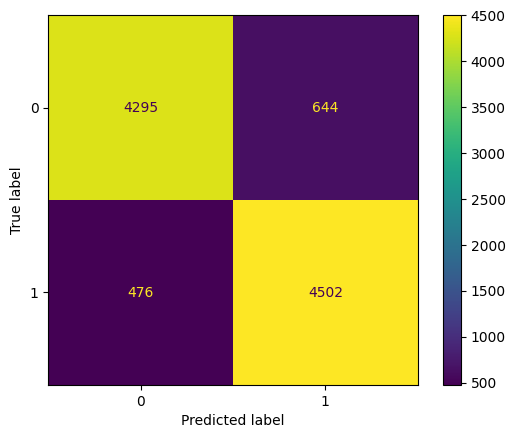

In [96]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Naive bayes

In [97]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [98]:
# Vectorize Text Data
vectorizer = TfidfVectorizer(stop_words='english')
X = data['text']
X_vectorized = vectorizer.fit_transform(X)

In [99]:
# Train-Test Split
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [100]:
# Train the Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [101]:
# Make Predictions and Evaluate the Model
y_pred = nb_model.predict(X_test)

# Evaluate the model
NB_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {NB_accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8634667742260764
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4939
           1       0.87      0.86      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



In [102]:
NB_accuracy = accuracy_score(y_test, y_pred)
NB_Precision =  precision_score(y_test, y_pred)
NB_recall = recall_score(y_test, y_pred)
NB_F1_Score = f1_score(y_test, y_pred)
NB_training_accuracy = nb_model.score(X_train, y_train)
NB_testing_accuracy = nb_model.score(X_test, y_test)

print(f"Naive Bayes Accuracy: ",NB_accuracy)
print(f"Naive Bayes Precision: ",NB_Precision)
print(f"Naive Bayes Recall: ",NB_recall)
print(f"Naive Bayes F1 Score: ",NB_F1_Score)
print(f"Naive Bayes Training Accuracy: ",NB_training_accuracy)
print(f"Naive Bayes Testing Accuracy: ",NB_testing_accuracy)

Naive Bayes Accuracy:  0.8634667742260764
Naive Bayes Precision:  0.8653225806451613
Naive Bayes Recall:  0.862193652069104
Naive Bayes F1 Score:  0.8637552827530691
Naive Bayes Training Accuracy:  0.9155930921467289
Naive Bayes Testing Accuracy:  0.8634667742260764


In [155]:
def Sentiment_prediction(sentence):
    vectorized_sentence = vectorizer.transform([sentence])

    sentence_prediction = nb_model.predict(vectorized_sentence)
    prediction_probability = nb_model.predict_proba(vectorized_sentence)

    return sentence_prediction, prediction_probability

movie_review = 'I felt like I was 14 again. Thank you Netflix!. it was a really great film enjoyed a lot '
predicted_class = Sentiment_prediction(movie_review)[0]
predicted_probability = Sentiment_prediction(movie_review)[1]

if predicted_class == 1 : print(f"Predicted Class: {predicted_class[0]}, Positive Review")
else: print(f"Predicted Class: {predicted_class}, Negative Review")

print(f"Prediction Probability: {predicted_probability}")

Predicted Class: 1, Positive Review
Prediction Probability: [[0.35033383 0.64966617]]


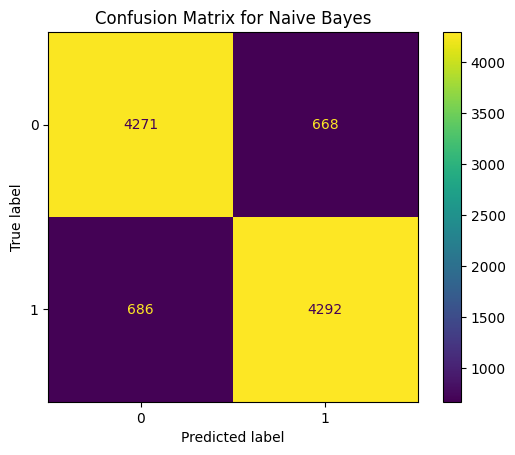

In [104]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for Naive Bayes")

plt.show()

## Comparing Machine Learning models

In [105]:
ml_algo_list = ["SVM", "logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes"]

In [107]:
ml_accuracy = [SVM_accuracy * 100 , LR_accuracy * 100 , DT_accuracy* 100 , RF_accuracy* 100 , NB_accuracy* 100 ]

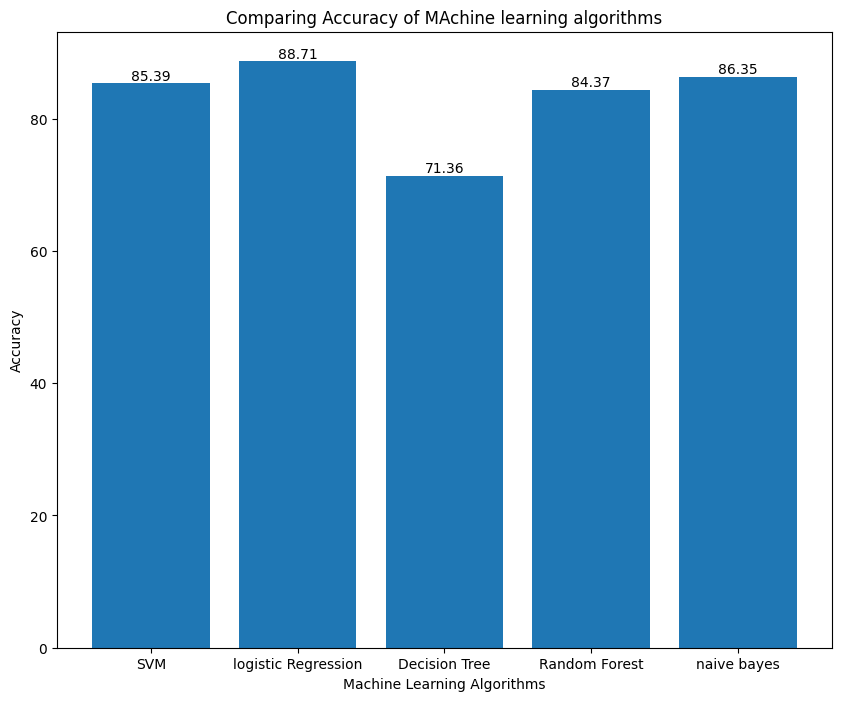

In [108]:
plt.figure(figsize=(10,8))
plt.bar(x = ml_algo_list, height = ml_accuracy)
plt.title("Comparing Accuracy of MAchine learning algorithms")
plt.xlabel('Machine Learning Algorithms')
plt.ylabel('Accuracy')

# Add numbers on top of the bars
for i, v in enumerate(ml_accuracy):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

plt.show()

In [110]:
ml_algo_list = ['SVM', "logistic Regression", 'Decision Tree', 'Random Forest', 'naive bayes']
ml_accuracy = [SVM_accuracy * 100 , LR_accuracy * 100 , DT_accuracy* 100 , RF_accuracy* 100 , NB_accuracy* 100 ]
ml_precision = [SVM_Precision * 100 , LR_Precision * 100 , DT_Precision* 100 , RF_Precision* 100 , NB_Precision* 100 ]
ml_recall = [SVM_recall * 100 , LR_recall * 100 , DT_recall* 100 , RF_recall* 100 , NB_recall* 100 ]
ml_f1_score = [SVM_F1_Score * 100 , LR_F1_Score * 100 , DT_F1_Score* 100 , RF_F1_Score* 100 , NB_F1_Score]

ML_algorithms = pd.DataFrame({
    'Machine Learning Algorithms': ml_algo_list,
    'Accuracy': ml_accuracy,
    'Precision': ml_precision,
    'Recall': ml_recall,
    'F1 Score': ml_f1_score
})

print(ML_algorithms)

  Machine Learning Algorithms   Accuracy  Precision     Recall   F1 Score
0                         SVM  85.388726  84.017737  87.545199  85.745204
1         logistic Regression  88.706262  87.485426  90.437927  88.937179
2               Decision Tree  71.362307  71.674777  71.012455  71.342079
3               Random Forest  84.370273  84.129829  84.873443  84.500000
4                 naive bayes  86.346677  86.532258  86.219365   0.863755


# Neural Network

## Artificial Neural Network

In [131]:
df_ANN = data.copy(deep = True)

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from keras.optimizers import Adam

In [133]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(df_ANN['text'].to_list())
sequences = tokenizer.texts_to_sequences(df_ANN['text'].astype(str).to_list())
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
df_ANN["sequences"] = list(padded)


In [134]:
df_ANN['sentiment'] = df_ANN['sentiment'].replace({'positive':1,'negative':0})

In [135]:
X = np.array(df_ANN["sequences"].to_list())
y = np.array(df_ANN['sentiment'].to_list())

In [136]:
df_ANN

,text,sentiment,sequences
0,one reviewer mentioned watching oz episode you...,1,"[3, 925, 58, 167, 357, 99, 489, 478, 19, 23, 1..."
1,wonderful little production filming technique ...,1,"[280, 41, 230, 53, 410, 187, 314, 228, 32, 435..."
2,thought wonderful way spend time hot summer we...,1,"[89, 280, 22, 976, 4, 772, 787, 484, 58, 93, 3..."
3,basically there family little boy jake think t...,0,"[537, 116, 117, 41, 196, 25, 116, 504, 551, 86..."
4,petter matteis love time money visually stunni...,1,"[29, 4, 190, 2, 28, 263, 689, 236, 1, 90, 878,..."
...,...,...,...
49995,thought movie right good job wasnt creative or...,1,"[89, 1, 99, 5, 171, 181, 110, 19, 853, 118, 15..."
49996,bad plot bad dialogue bad acting idiotic direc...,0,"[18, 34, 18, 277, 18, 38, 827, 519, 580, 123, ..."
49997,catholic taught parochial elementary school nu...,0,"[252, 220, 252, 955, 47, 5, 235, 20, 159, 612,..."
49998,going disagree previous comment side maltin on...,0,"[71, 756, 333, 342, 3, 192, 834, 584, 162, 138..."


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

In [138]:
# Clear the session of any previous ANN
clear_session()

In [ ]:
from tesnsorflow.keras.models import Sequential
from tensorflow.keras import layers

# The Embedding Layer is used in Natural Language Processing (NLP) tasks to represent words (or tokens) as dense vectors in a way that captures their meaning and relationships.
nn_model = Sequential()
nn_model.add(layers.Embedding(input_dim=1000, output_dim=64, input_length=100)) # converts into dense vector of size 64

nn_model.add(layers.GlobalAveragePooling1D()) # reduce complexity of the sequence by  averaging the values
nn_model.add(layers.Dense(32, activation='tanh'))
nn_model.add(layers.Dense(16, activation='tanh'))
nn_model.add(layers.Dense(1, activation='sigmoid'))

nn_model.build(input_shape=(None, 100))  # Define the input shape
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,625 (260.25 KB)

 Trainable params: 66,625 (260.25 KB)

 Non-trainable params: 0 (0.00 B)

In [140]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Epoch 1/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6253 - loss: 0.6627 - val_accuracy: 0.8021 - val_loss: 0.4564
Epoch 2/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8230 - loss: 0.4072 - val_accuracy: 0.8408 - val_loss: 0.3603
Epoch 3/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8515 - loss: 0.3421 - val_accuracy: 0.8477 - val_loss: 0.3485
Epoch 4/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8621 - loss: 0.3301 - val_accuracy: 0.8490 - val_loss: 0.3475
Epoch 5/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8618 - loss: 0.3269 - val_accuracy: 0.8470 - val_loss: 0.3492
Epoch 6/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8614 - loss: 0.3244 - val_accuracy: 0.8492 - val_loss: 0.3487
Epoch 7/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8690 - loss: 0.3124 - val_accuracy: 0.8389 - val_loss: 0.3613
Epoch 8/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8602 - loss: 0.3252 - val_accuracy: 0.8468 - val_loss

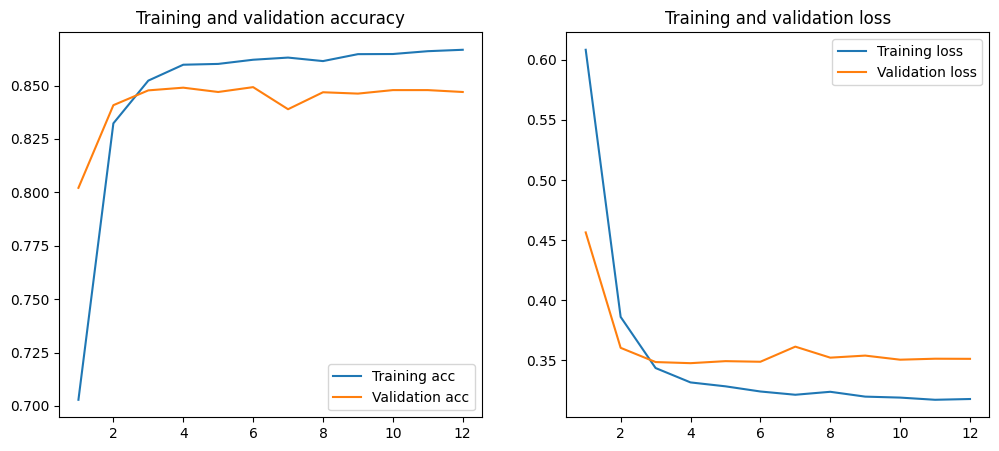

In [141]:
# Train the model
history = nn_model.fit(X_train, y_train, epochs=12, verbose=True, validation_split=0.2, batch_size=500)
plot_history(history)

# Evaluate the model
loss, accuracy = nn_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [142]:
y_pred = nn_model.predict(X_test)
y_pred = (y_pred > 0.5)

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [143]:
ANN_accuracy = accuracy_score(y_test, y_pred)
ANN_Precision =  precision_score(y_test, y_pred)
ANN_recall = recall_score(y_test, y_pred)
ANN_F1_Score = f1_score(y_test, y_pred)

ANN_training_accuracy = history.history['accuracy'][-1]
ANN_testing_accuracy = history.history['val_accuracy'][-1]

Evaluation_table = pd.DataFrame({
    'Model': ['Artificial Neural Network'] ,
    'Training Accuracy': [ANN_training_accuracy * 100],
    'Testing Accuracy': [ANN_testing_accuracy * 100] ,
    'Accuracy': [ANN_accuracy * 100],
    'Precision': [ANN_Precision * 100],
    'Recall': [ANN_recall * 100],
    'F1 Score': [ANN_F1_Score * 100]
})

Evaluation_table

,Model,Training Accuracy,Testing Accuracy,Accuracy,Precision,Recall,F1 Score
0,Artificial Neural Network,86.672759,84.696835,85.005546,83.867775,86.310858,85.07178


In [160]:
reviews=["This so good! I love it!",
            "This is awesome movie! But the tickets were bit expensive",
            "I'm happy with it, unfortunately there were less shows.",
            "I hate this movie, it's bad.",
            "Are you joking?? This movie is shit!!!",
            "It could be much better.",
            "Very bad movie.",
            "I don't like this product, it breaks all the time."]

sentence_sequence = tokenizer.texts_to_sequences(reviews)

vectorized_sentence = pad_sequences(newsequences, maxlen=100, padding='post', truncating='post')


prediction_nn = nn_model.predict(vectorized_sentence)

for i in range(len(reviews)):

    score = prediction_nn[i][0]
    if score > 0.5:
        label = "Positive"
    else:
        label = "Negative"

    print(my_reviews[i] + " ---> Score: " + str(prediction_score) + " - " + prediction_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This so good! I love it! ---> Score: 0.6461444 - Positive
This is awesome! But a bit expensive ---> Score: 0.6461444 - Positive
I'm happy with it, unfortunately it arrived quite late. ---> Score: 0.6461444 - Positive
I hate this product, it's bad quality. ---> Score: 0.6461444 - Positive
Are you joking?? This product is shit!!! ---> Score: 0.6461444 - Positive
It could be much better. ---> Score: 0.6461444 - Positive
Very bad product. ---> Score: 0.6461444 - Positive
I don't like this product, it breaks all the time. ---> Score: 0.6461444 - Positive


### Tuned model ANN

In [144]:
# Clear the session of any previous ANN
clear_session()

In [145]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df_ANN['text'].to_list())
sequences = tokenizer.texts_to_sequences(df_ANN['text'].astype(str).to_list())
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
df_ANN["sequences"] = list(padded)

In [146]:
df_ANN['sentiment'] = df_ANN['sentiment'].replace({'positive':1,'negative':0})

In [147]:
X = np.array(df_ANN["sequences"].to_list())
y = np.array(df_ANN['sentiment'].to_list())

In [148]:
df_ANN

,text,sentiment,sequences
0,one reviewer mentioned watching oz episode you...,1,"[3, 1013, 925, 58, 167, 357, 99, 489, 478, 194..."
1,wonderful little production filming technique ...,1,"[280, 41, 230, 1217, 1582, 1339, 53, 410, 187,..."
2,thought wonderful way spend time hot summer we...,1,"[89, 280, 22, 976, 4, 772, 1265, 1053, 787, 48..."
3,basically there family little boy jake think t...,0,"[537, 116, 117, 41, 196, 25, 116, 504, 551, 86..."
4,petter matteis love time money visually stunni...,1,"[29, 4, 190, 1879, 1230, 2, 28, 263, 689, 236,..."
...,...,...,...
49995,thought movie right good job wasnt creative or...,1,"[89, 1, 99, 5, 171, 181, 1326, 110, 19, 853, 1..."
49996,bad plot bad dialogue bad acting idiotic direc...,0,"[18, 34, 18, 277, 18, 38, 827, 519, 1403, 580,..."
49997,catholic taught parochial elementary school nu...,0,"[252, 1579, 220, 252, 955, 47, 1039, 5, 1313, ..."
49998,going disagree previous comment side maltin on...,0,"[71, 756, 333, 342, 3, 192, 834, 584, 162, 138..."


In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

In [150]:
from keras.models import Sequential
from keras import layers

nn_tuned_model = Sequential()
nn_tuned_model.add(layers.Embedding(input_dim=2000, output_dim=128, input_length=100))
nn_tuned_model.add(layers.GlobalAveragePooling1D())
nn_tuned_model.add(layers.Dense(64, activation='relu'))
nn_tuned_model.add(layers.Dropout(0.5))
nn_tuned_model.add(layers.Dense(32, activation='relu'))
nn_tuned_model.add(layers.Dropout(0.5))
nn_tuned_model.add(layers.Dense(1, activation='sigmoid'))

nn_tuned_model.build(input_shape=(None, 100))  # Define the input shape
nn_tuned_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
nn_tuned_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,369 (1.02 MB)

 Trainable params: 266,369 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8981 - loss: 0.2377 - val_accuracy: 0.8484 - val_loss: 0.4019
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9027 - loss: 0.2347 - val_accuracy: 0.8559 - val_loss: 0.4133
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9023 - loss: 0.2342 - val_accuracy: 0.8510 - val_loss: 0.3925
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8984 - loss: 0.2396 - val_accuracy: 0.8567 - val_loss: 0.3996
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9034 - loss: 0.2311 - val_accuracy: 0.8528 - val_loss: 0.4029
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9008 - loss: 0.2329 - val_accuracy: 0.8525 - val_loss: 0.4066
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9046 - loss: 0.2298 - val_accuracy: 0.8529 - val_loss: 0.4203
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9043 - loss: 0.2293 - val_accuracy: 0.8486 - val_loss

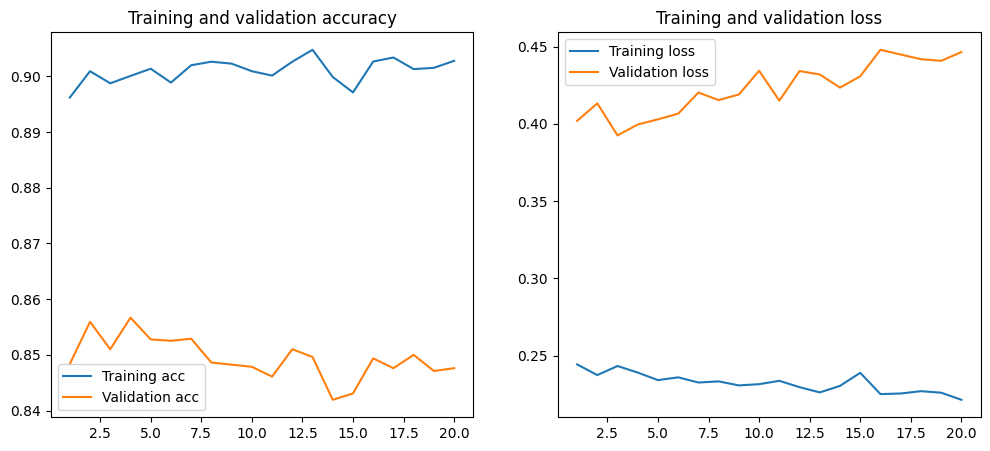

In [162]:
# Train the model
history = nn_tuned_model.fit(X_train, y_train, epochs=20, verbose=True, validation_split=0.2, batch_size=500)
plot_history(history)

# Evaluate the model
loss, accuracy = nn_tuned_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = nn_tuned_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


In [179]:
y_pred = nn_tuned_model.predict(X_test)
y_pred = (y_pred > 0.5)

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [180]:
ANN_accuracy = accuracy_score(y_test, y_pred)
ANN_Precision =  precision_score(y_test, y_pred)
ANN_recall = recall_score(y_test, y_pred)
ANN_F1_Score = f1_score(y_test, y_pred)

ANN_training_accuracy = history.history['accuracy'][-1]
ANN_testing_accuracy = history.history['val_accuracy'][-1]

Evaluation_table = pd.DataFrame({
    'Model': ['Artificial Neural Network'] ,
    'Training Accuracy': [ANN_training_accuracy * 100],
    'Testing Accuracy': [ANN_testing_accuracy * 100] ,
    'Accuracy': [ANN_accuracy * 100],
    'Precision': [ANN_Precision * 100],
    'Recall': [ANN_recall * 100],
    'F1 Score': [ANN_F1_Score * 100]
})

Evaluation_table

,Model,Training Accuracy,Testing Accuracy,Accuracy,Precision,Recall,F1 Score
0,Artificial Neural Network,90.277952,84.759861,84.773621,82.059989,88.612752,85.210578


# Transformer

## BERT Model

In [163]:
data = project_data[['text','sentiment']]

In [164]:
data['sentiment'] = data['sentiment'].replace({'positive':1,'negative':0})
data.head(2)

,text,sentiment
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1


In [165]:
import pandas as pd
from datasets import Dataset

# Convert the DataFrame to a Dataset object
dataset = Dataset.from_pandas(data)

# Split the dataset into train and test sets
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [166]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

In [167]:
from transformers import BertForSequenceClassification

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [168]:
# Bert Model Structure.
print(bert_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [169]:
def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': examples['sentiment']}, batched=True)
    return dataset

train_dataset = format_dataset(train_dataset)
test_dataset = format_dataset(test_dataset)


Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

In [170]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=0.5,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=3,
    warmup_steps=250,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    evaluation_strategy="epoch"
)

In [171]:
from transformers import Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [172]:
trainer = Trainer(model=bert_model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset, compute_metrics=compute_metrics)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.320400,0.361596,0.888575,0.888350,0.874478,0.902669


TrainOutput(global_step=3306, training_loss=0.43908015959059477, metrics={'train_runtime': 2464.8769, 'train_samples_per_second': 8.046, 'train_steps_per_second': 1.341, 'total_flos': 5219070894120960.0, 'train_loss': 0.43908015959059477, 'epoch': 0.5000756315232189})

In [173]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.3615959584712982, 'eval_accuracy': 0.888575173943733, 'eval_f1': 0.8883500050520361, 'eval_precision': 0.8744778197732246, 'eval_recall': 0.9026694045174538, 'eval_runtime': 317.8632, 'eval_samples_per_second': 31.199, 'eval_steps_per_second': 10.401, 'epoch': 0.5000756315232189}


In [174]:
# Extracting the metrics from the evaluation results
Transformer_accuracy = eval_results['eval_accuracy'] * 100
Transformer_precision = eval_results['eval_precision'] * 100
Transformer_recall = eval_results['eval_recall'] * 100
Transformer_F1_Score = eval_results['eval_f1'] * 100

print(f"Transformer Accuracy: {Transformer_accuracy:.4f}")
print(f"Transformer Precision: {Transformer_precision:.4f}")
print(f"Transformer Recall: {Transformer_recall:.4f}")
print(f"Transformer F1 Score: {Transformer_F1_Score:.4f}")

Transformer Accuracy: 88.8575
Transformer Precision: 87.4478
Transformer Recall: 90.2669
Transformer F1 Score: 88.8350


In [175]:
predictions = trainer.predict(test_dataset)

In [176]:
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

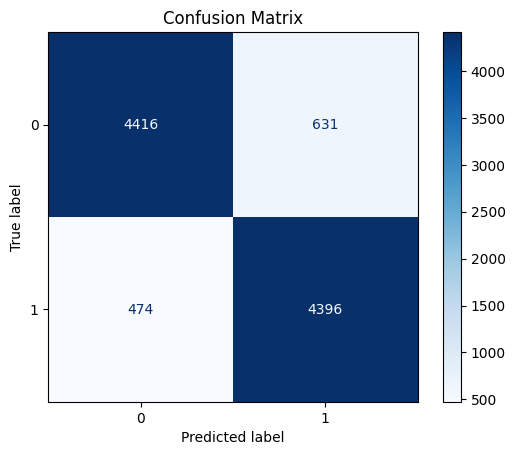

In [177]:
# Create confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


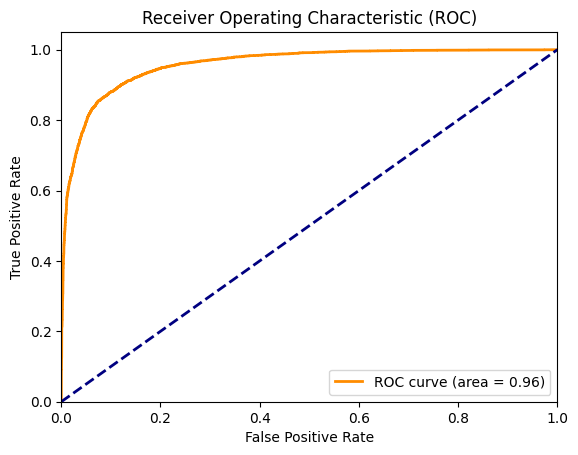

In [178]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(labels, predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


# Exporting Website

In [ ]:
## Exporting th pickle model for creating the website

# import pickle

# with open('model.pickle', 'wb') as f:
#     pickle.dump(trainer, f)